In [1]:
from PIL import Image
import cv2
import json
from cv2 import imshow
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);
import time

import sys
import os
sys.path.append(os.path.abspath(''))
os.chdir("../")
Main_dir = os.getcwd()+"/"
print(Main_dir)
from tools.misc_fucntions import *
from tools.projection import World3DInto2DImage, project3Dto2D
from tools.plot import *
#from tools import knownWorld3dBoxPoints, projectedKnown3dBoxPoints, pointsOnALine, cat_points, cat_name_ids
from tools.Key3d import keypoints3d, getPwsPT, getPwsPT_ordered
from tools.pnp import *
from tools.argsinf import args, colors, cat_names, results_dir, example_dir, readargs
from tools.implot import imgplot, objplot
from models import build_model
from inf.load import *
import torchvision.transforms as T
from configparser import ConfigParser, ExtendedInterpolation

import math

from PIL import Image
import requests
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, clear_output



/home/maneesh/Desktop/LAB2.0/TRPE_Multi_Object/
args.device :  0
config :  config.ini
No module named 'pytorch3d'


In [2]:
CLASSES = [
    "dog house center", "dog house", "house", "super structure", "whole ship", "ship stern",
]
OBJ_LIST = ["dog house center", "dog house", "house long", "super structure", "whole ship", "ship stern"]
COLORS = ["red", "darksalmon", "Orange", "gold", "greenyellow", "limegreen", "darkgreen", "cyan", "blue", "magenta"]

In [3]:
checkpoint_dir = "/home/maneesh/Desktop/LAB2.0/DATA-FDCL/CheckpointsE01/E01rev0_12-25-2023_Multi-6X-H332k.NH102k__DETR-1.1-NQ6_NC6__DT435454/"
checkpoint_file = "E01rev0_12-25-2023_Multi-6X-H332k.NH102k__DETR-1.1-NQ6_NC6__DT435454.pth"
args = readargs(checkpoint_dir)

args.device :  cuda:0
config :  /home/maneesh/Desktop/LAB2.0/DATA-FDCL/CheckpointsE01/E01rev0_12-25-2023_Multi-6X-H332k.NH102k__DETR-1.1-NQ6_NC6__DT435454/config.ini


In [4]:
config = ConfigParser(interpolation=ExtendedInterpolation())
configdirlist = config.read('test_config.ini')
examples_names = json.loads(config.get('Test', 'Test_samples'))

points_only = args.points_only
num_keys = args.num_keys
name = args.testname
#result = example+"_"+name
ext = args.ext
gt = args.gt
zn = args.zero_numbering
detr_version = args.detr_version
nq = args.num_queries
nc = args.num_classes
print(detr_version,nq,nc)
Pws = getPwsPT_ordered(nq, nc, device='cuda:0', dtype=torch.float32)
model, criterion, postprocessors = build_model(args)
#model.to("cpu")
#model.eval()
print("Loading ... ", args.checkpoint_dir + args.testname + "/"+ args.snapshot)


checkpoint = torch.load(checkpoint_dir + checkpoint_file, map_location='cuda')
#checkpoint = torch.load("/home/maneesh/Desktop/Detr_pose_estimation_for_ship/snapshots/checkpoint_Multi_02_Default_EP100_DSIZ-11800.pth")
#print("Loading ../checkpoint_"+ name +".pth file")
model.load_state_dict(checkpoint["model"])
model.eval()
#Dir = Main_dir + "examples/groundtruth/" + example + "/"

1.1 6 6
cat id  [1 2 3 4 5 6]
DETR 1.1 network called
Number of classes :  6
loaded resnet from path : 
/home/maneesh/Desktop/LAB2.0/TRPE_Multi_Object/scripts/models/resnet/tmp/res50_coco_512x512-5521bead_20200816.pth
load pretrained backend model
Loading ...  /home/maneesh/Desktop/LAB2.0/DATA-FDCL/CheckpointsE01/E01rev0_12-25-2023_Multi-6X-H332k.NH102k__DETR-1.1-NQ6_NC6__DT435454/E01rev0_12-25-2023_Multi-6X-H332k.NH102k__DETR-1.1-NQ6_NC6__DT435454.pth


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [5]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [7]:
im = Image.open("/home/maneesh/Desktop/LAB2.0/DATA-FDCL/Data-Testing/Test_44/Test_44_imgs/118.png")
#im = Image.open("/home/maneesh/Desktop/LAB2.0/DATA-FDCL/Data-Testing/offline_saved_Normal_20m/offline_saved_Normal_20m_imgs/000326.jpg")
# mean-std normalize the input image (batch-size: 1)
newsize = (640, 480)
im = im.resize(newsize)
img = transform(im).unsqueeze(0)

tensor([True, True, True, True, True, True])


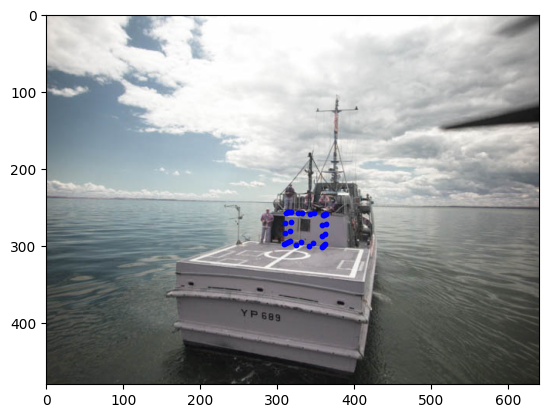

In [8]:
confidance = 0.95
# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
# probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
# keep = probas.max(-1).values > 0.9
# print(keep)
predictions = outputs['pred_logits'].softmax(-1)[0, :, :-1]
confidance_val = predictions.max(-1).values
keep = confidance_val > confidance  #keep is tensor([ True, False, False,  True, ... ]) which is used to filter output based on confidance
print(keep)

catIDs_keep = torch.from_numpy(np.expand_dims(np.array([p.argmax().numpy()+1 for p in predictions[keep]]), axis=1))
catIDs_all = torch.from_numpy(np.expand_dims(np.array([p.argmax().numpy()+1 for p in predictions]), axis=1))

keypoints_keep = outputs['pred_keypoints'][0, keep] # outputs['pred_keypoints'].size() = [1, NQ, 64]
keypoints_all = outputs['pred_keypoints'][0]

w, h = im.size
scaleup_keep = torch.tensor([w, h] * num_keys, dtype = torch.float32).repeat(keypoints_keep[:,:num_keys*2].shape[0],1)
scaleup_all = torch.tensor([w, h] * num_keys, dtype = torch.float32).repeat(keypoints_all[:,:num_keys*2].shape[0],1)

keypoints_keep_scaledup = keypoints_keep[:,:num_keys*2]  *  scaleup_keep
keypoints_all_scaledup = keypoints_all[:,:num_keys*2]  *  scaleup_all

Keypoints_keep = keypoints_keep_scaledup.view(-1, num_keys, 2)
Keypoints_all = keypoints_all_scaledup.view(-1, num_keys, 2).numpy()
objplot(Keypoints_keep[5], color='b', size=10)
#plt.scatter(Keypoints_all_s[5,:,0], Keypoints_all_s[5,:,1],marker="o")
plt.imshow(im)


## Visualize encoder-decoder multi-head attention weights
Here we visualize attention weights of the last decoder layer. This corresponds to visualizing, for each detected objects, which part of the image the model was looking at to predict this specific bounding box and class.
We will use hooks to extract attention weights (averaged over all heads) from the transformer.

In [9]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]
print(dec_attn_weights.size())

torch.Size([1, 6, 300])


In [10]:
print(catIDs_all)
cat_orig = [0,1,2,3,4,5]
cls = np.array(CLASSES)[catIDs_all.squeeze(1).numpy()-1]
clr = np.array(COLORS)[catIDs_all.squeeze(1).numpy()-1]
cog = np.array(cat_orig)[catIDs_all.squeeze(1).numpy()-1]
print(cls)
print(clr)
print(cog)


tensor([[5],
        [3],
        [6],
        [4],
        [2],
        [1]])
['whole ship' 'house' 'ship stern' 'super structure' 'dog house'
 'dog house center']
['greenyellow' 'Orange' 'limegreen' 'gold' 'darksalmon' 'red']
[4 2 5 3 1 0]


/tmp/ipykernel_63821/1477597210.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


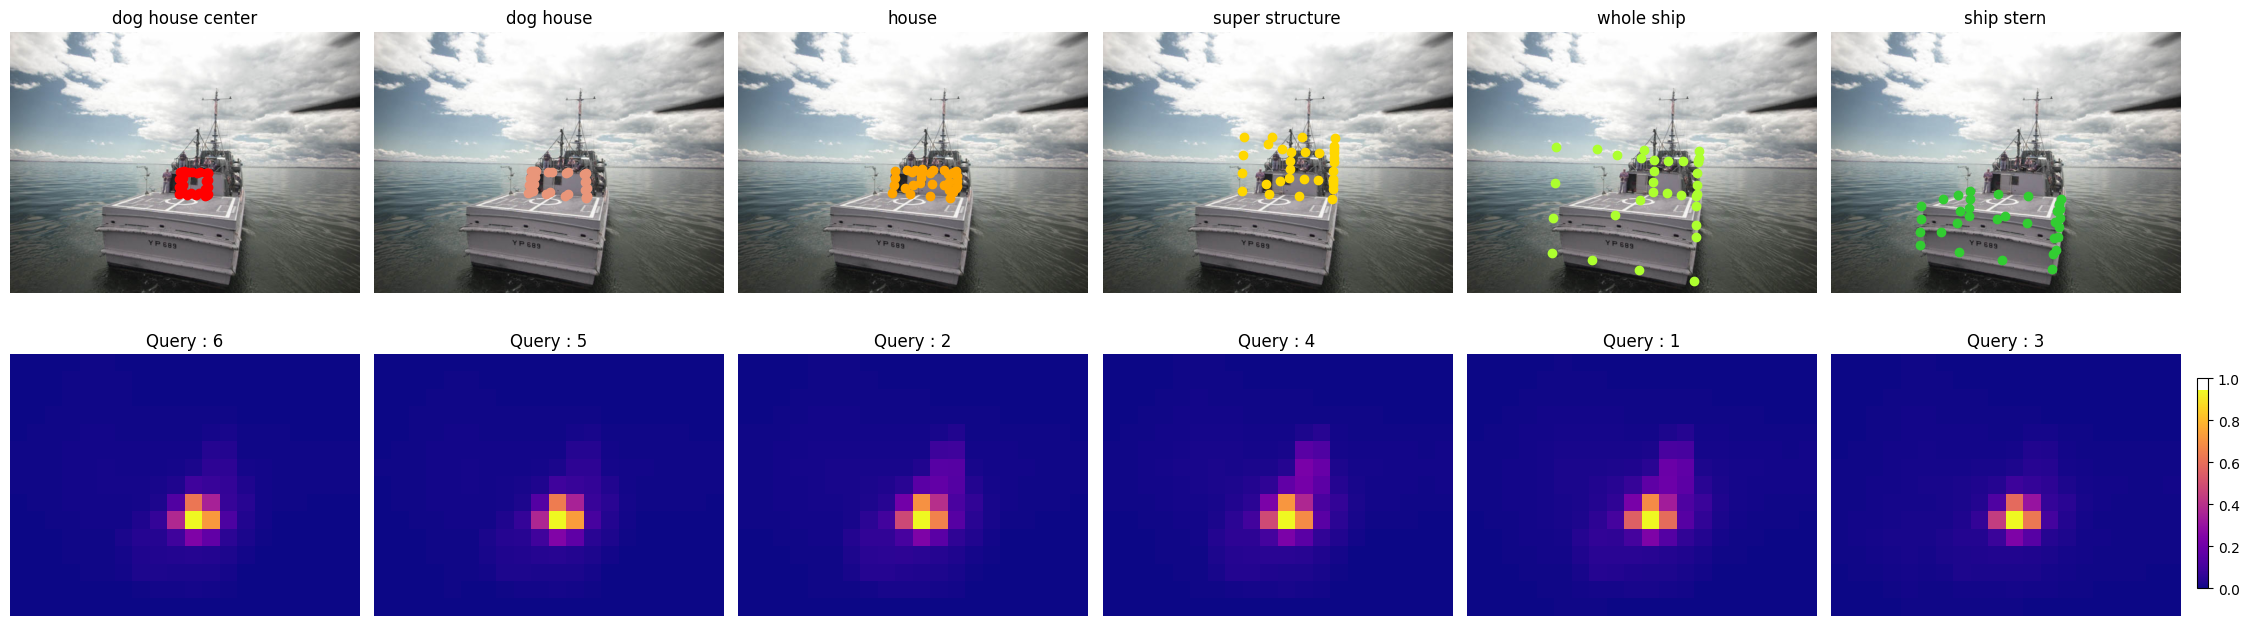

In [11]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]
ci =0
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(22, 7))

# Compute the min and max of dec_attn_weights
min_val = dec_attn_weights.min()
max_val = dec_attn_weights.max()

# Perform min-max normalization
dec_attn_weights_norm = (dec_attn_weights - min_val) / (max_val - min_val)

for idx, ax_i in zip(keep.nonzero(), axs.T):
    idx_org = torch.tensor([np.where(cog == idx.item())[0][0]]) # re-arranged index is idx_org. 
    #idx_org = idx #If we use idx it will plot figures by arranging queries
    ax = ax_i[1]
    dec = ax.imshow(dec_attn_weights_norm[0, idx_org].view(h, w), cmap='plasma', interpolation='nearest')
    
    ax.axis('off') 
    ax.set_title(f'Query : {idx_org.item()+1}')
    ax = ax_i[0]
    ax.imshow(im)
    ax.scatter(Keypoints_all[idx_org.item(),:,0], Keypoints_all[idx_org.item(),:,1],marker="o", c=clr[idx_org])
    ax.axis('off')
    ax.set_title(cls[idx_org])
    ci+=1

cax = fig.add_axes([1.001, 0.122, 0.005, 0.3])

cbar =fig.colorbar(dec,cax=cax, orientation='vertical')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
fig.tight_layout()

/tmp/ipykernel_63821/133051654.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


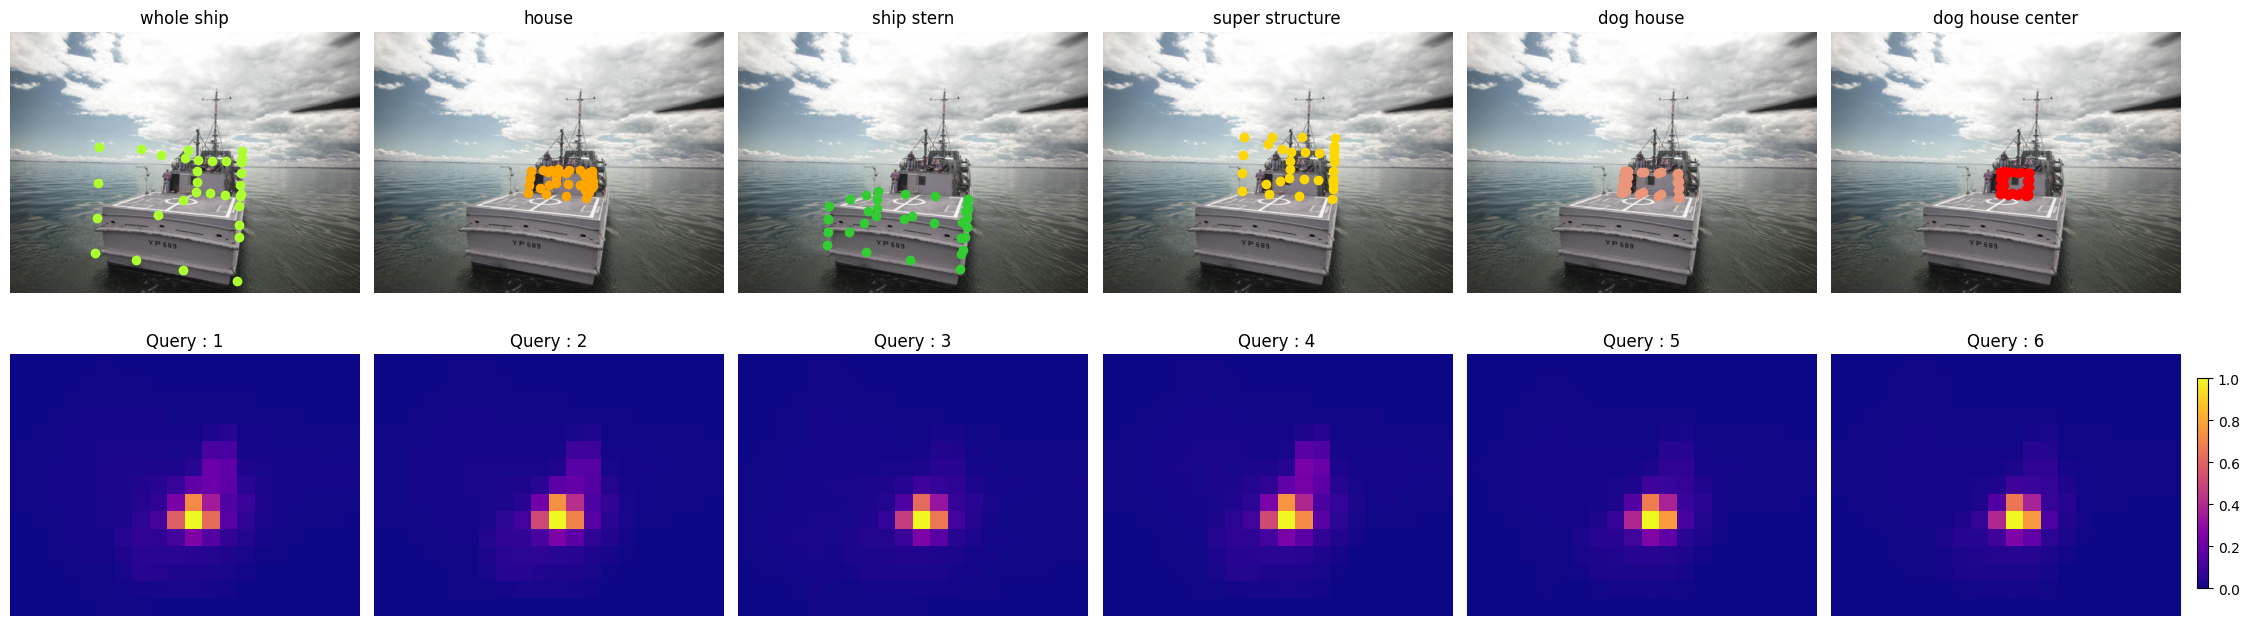

In [12]:
cat_orig = [1,2,3,4,5,6]

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]
ci =0
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(22, 7))

# Compute the min and max of dec_attn_weights
min_val = dec_attn_weights.min()
max_val = dec_attn_weights.max()

# Perform min-max normalization
dec_attn_weights_norm = (dec_attn_weights - min_val) / (max_val - min_val)

for idx, ax_i in zip(keep.nonzero(), axs.T):
    ax = ax_i[1]
    dec = ax.imshow(dec_attn_weights_norm[0, idx].view(h, w), cmap='plasma', interpolation='nearest')
    
    ax.axis('off')
    ax.set_title(f'Query : {idx.item()+1}')
    ax = ax_i[0]
    ax.imshow(im)
    ax.scatter(Keypoints_all[idx.item(),:,0], Keypoints_all[idx.item(),:,1],marker="o", c=clr[idx])
    ax.axis('off')
    ax.set_title(cls[idx])
    ci+=1

cax = fig.add_axes([1.001, 0.122, 0.005, 0.3])

cbar =fig.colorbar(dec,cax=cax, orientation='vertical')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
fig.tight_layout()

### Visualize encoder self-attention weights

In this section we visualize the model's self-attention. This allows us to gain intuition on how the model encodes the objects. In particular, we see from the attention response maps that the encoder already participate to the instance separation process.

Let's start by visualizing the shape of the encoder self-attention:

In [13]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([300, 300])
Feature map:             torch.Size([1, 2048, 15, 20])


As we can see, the self-attention is a square matrix of size `[H * W, H * W]`, where `H` and `W` are the sizes of the feature map, so we reshape it so that it has a more interpretable representation of `[H, W, H, W]`.

In [14]:
# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
print(shape)
# and reshape the self-attention to a more interpretable shape
print(enc_attn_weights[0].size())
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

torch.Size([15, 20])
torch.Size([300, 300])
Reshaped self-attention: torch.Size([15, 20, 15, 20])


Now that we have the self-attention into a more interpretable representation, let's try to visualize it.
Given that the self-attention is a very large matrix, let's start by selecting a few reference points where we will be looking at the attention.

torch.Size([15, 20])
10 5
torch.Size([15, 20])
8 9
torch.Size([15, 20])
6 11
torch.Size([15, 20])
11 10
torch.Size([15, 20])
11 16
torch.Size([15, 20])
3 16


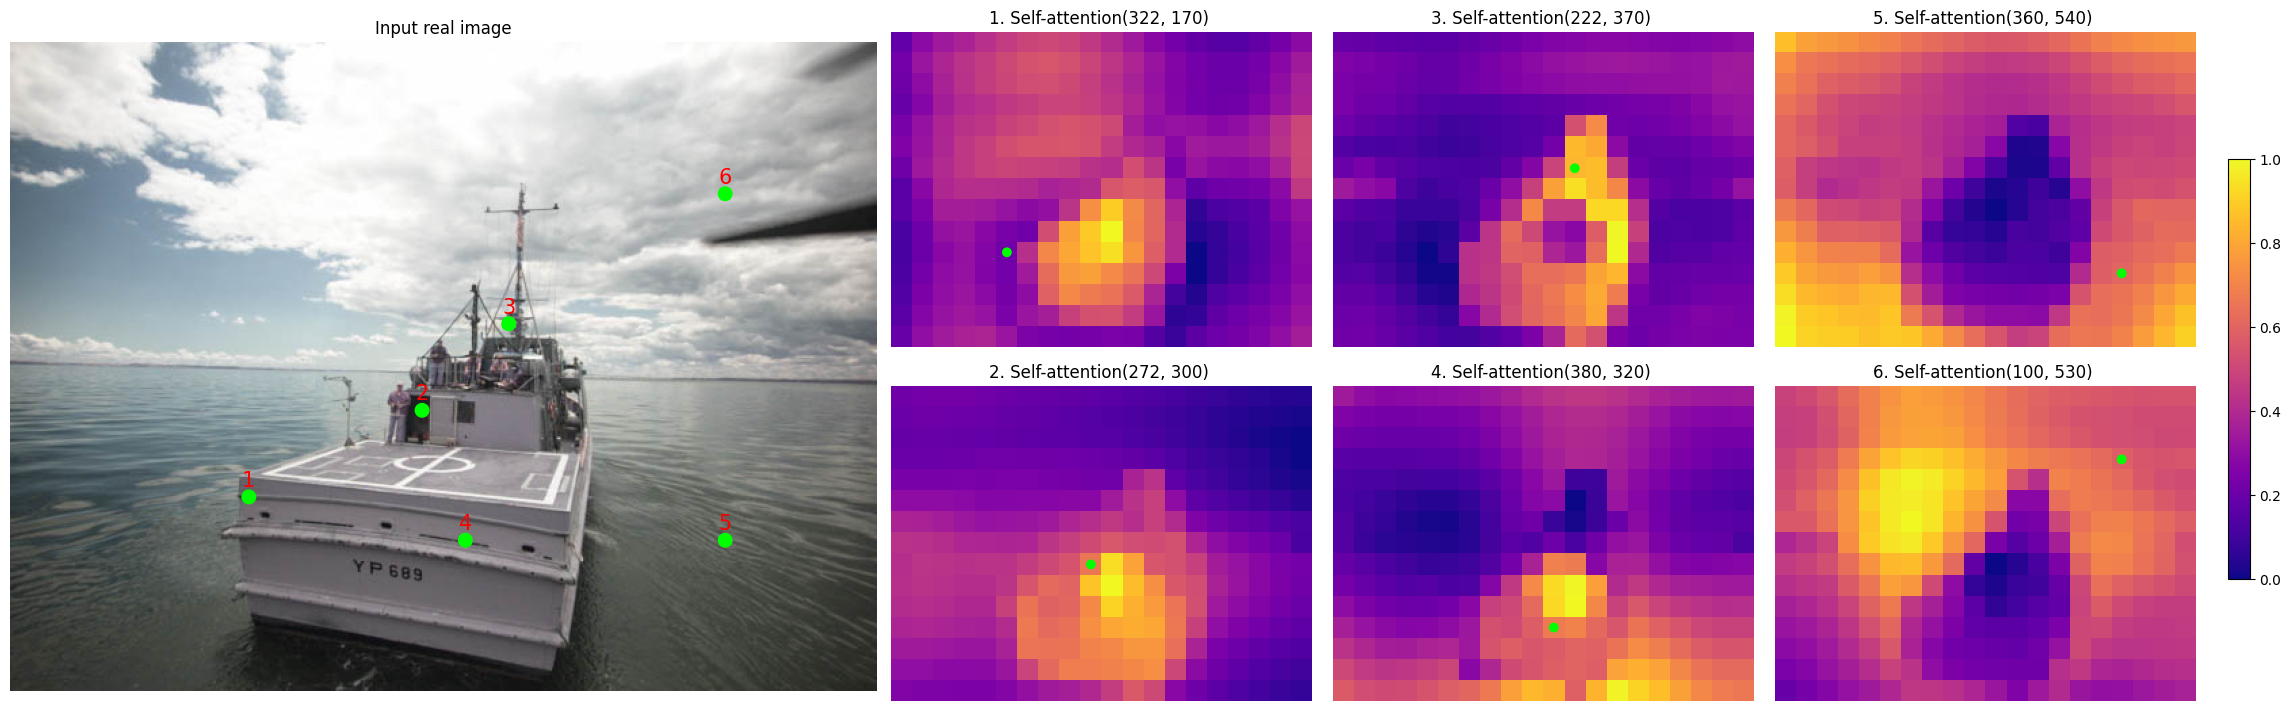

In [31]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(322, 170), (272,300), (222,370), (380, 320),(360, 540),(100,530),]
st = ["Sea", "Sky", "Super structure", "Ship stern", "Ship stern", "Ship stern"]
# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(22 , 7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 5)
axs = [
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 2]),
    fig.add_subplot(gs[0, 3]),
    fig.add_subplot(gs[1, 3]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# Compute the min and max of dec_attn_weights
min_val = sattn.min()
max_val = sattn.max()

# Perform min-max normalization
sattnn = (sattn - min_val) / (max_val - min_val)

# for each one of the reference points, let's plot the self-attention
# for that point
i = 0
for idx_o, ax in zip(idxs, axs):
    i +=1
    
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    print(sattnn[..., idx[0], idx[1]].shape)
    ax.imshow(sattnn[..., idx[0], idx[1]], cmap='plasma', interpolation='nearest')
    print(idx[0], idx[1])
    ax.add_patch(plt.Circle((idx[1], idx[0]), 0.2, color='lime'))
    ax.axis('off')
    #ax.set_title(f'self-attention{idx_o}')
    ax.set_title(f'{i}. Self-attention{idx_o} ')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 0:-3])
fcenter_ax.imshow(im)
i = 0
for (y, x) in idxs:
    i +=1
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 6, color='lime'))
    fcenter_ax.text(x * scale-5, y * scale-8, str(i), color='red',fontsize=15)
    fcenter_ax.axis('off')
fcenter_ax.set_title(f'Input real image')

cax = fig.add_axes([1.01, 0.18, 0.01, 0.6])

cbar =fig.colorbar(dec,cax=cax, orientation='vertical')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])